In [ ]:
!pip install --quiet optuna
!pip install -q shap
!pip install category_encoders

In [ ]:
##Importing All the Required Library In the Python Shell
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import optuna 
import shap 
import pickle

from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from pathlib import Path

from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [ ]:
#Importing all the dataset in the form of CSV files from the Notebook
#The Below code is use to import all the dataset into the python
p1gen = pd.read_csv('/content/Plant_1_Generation_Data.csv')
p1wea = pd.read_csv('/content/Plant_1_Weather_Sensor_Data.csv')
p2gen = pd.read_csv('/content/Plant_2_Generation_Data.csv')
p2wea = pd.read_csv('/content/Plant_2_Weather_Sensor_Data.csv')
p1gen.head(10)

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0
5,15-05-2020 00:00,4135001,VHMLBKoKgIrUVDU,0.0,0.0,0.0,7206408.0
6,15-05-2020 00:00,4135001,WRmjgnKYAwPKWDb,0.0,0.0,0.0,7028673.0
7,15-05-2020 00:00,4135001,ZnxXDlPa8U1GXgE,0.0,0.0,0.0,6522172.0
8,15-05-2020 00:00,4135001,ZoEaEvLYb1n2sOq,0.0,0.0,0.0,7098099.0
9,15-05-2020 00:00,4135001,adLQvlD726eNBSB,0.0,0.0,0.0,6271355.0


In [ ]:
#The Below Code is use to change the column name for the simplicity of the code 
p1gen.columns= ['dt_time', 'plant_id', 'source_key', 'dc_power', 'ac_power', 'daily_yield', 'total_yield']
p1wea.columns = ['dt_time', 'plant_id', 'source_key', 'amb_temp', 'mod_temp', 'irrad']
p2gen.columns = ['dt_time', 'plant_id', 'source_key', 'dc_power', 'ac_power', 'daily_yield', 'total_yield']
p2wea.columns = ['dt_time', 'plant_id', 'source_key', 'amb_temp', 'mod_temp', 'irrad']

In [ ]:
# The Below code is use to check if the date and time format in the standard form
dfs = [p1gen, p1wea, p2gen,p2wea]
for i in dfs:
    print('start date ',i.dt_time.min(), 'end date ',i.dt_time.max())

start date  01-06-2020 00:00 end date  31-05-2020 23:45
start date  2020-05-15 00:00:00 end date  2020-06-17 23:45:00
start date  2020-05-15 00:00:00 end date  2020-06-17 23:45:00
start date  2020-05-15 00:00:00 end date  2020-06-17 23:45:00


In [6]:
# The Below code is use to change the date and time format in the standard form
# We have peformed this additional step just to make sure that the date is in
# one format
p1gen['dt_time']= pd.to_datetime(p1gen['dt_time'],format='%d-%m-%Y %H:%M')
p1wea['dt_time']= pd.to_datetime(p1wea['dt_time'],format='%Y-%m-%d %H:%M:%S')
p2gen['dt_time']= pd.to_datetime(p2gen['dt_time'],format='%Y-%m-%d %H:%M')
p2wea['dt_time']= pd.to_datetime(p2wea['dt_time'],format='%Y-%m-%d %H:%M:%S')

In [7]:
#The Below code is use to simplify the data to convert this into the categorical 
#varible
for i in dfs:
    i["source_key"] =  i["source_key"].astype('category')
    i["simp_source"] = i["source_key"].cat.codes
p1gen['plant_id_new'] = 1
p1wea['plant_id_new'] = 1
p2gen['plant_id_new'] = 2
p2wea['plant_id_new'] = 2

#THe Below Code is used to TAke the column Plant and solar array together to work
for i in dfs:
    i['plant_id_new'] = i['plant_id_new'].astype('string')
    i['simp_source'] = i['simp_source'].astype('string')
    i['plant_array'] = i['plant_id_new'] + '/' + i['simp_source']
    i['plant_id_new'] = i['plant_id_new'].astype('category')
    i['simp_source'] = i['simp_source'].astype('category')

In [8]:
# The Below code is use to Combine climatic data with energy data
for i in dfs:
    print(i.dt_time.count())
p1gen_merge = pd.merge(p1gen, p1wea, how='inner', on = 'dt_time')
p2gen_merge = pd.merge(p2gen, p2wea, how='inner', on = 'dt_time')

# The Below Code is use to Merge the COmbined Data Together in a single data frame
df = pd.concat([p1gen_merge,p2gen_merge], axis = 0)

68778
3182
67698
3259


In [9]:
#THe Below code is use to remove the redundant column from the datsaet and 
#only keep the column to be used 
df = df[['dt_time','plant_array_x','dc_power', 'ac_power', 'daily_yield','total_yield','amb_temp',
        'mod_temp','irrad','simp_source_x', 'plant_id_new_x']]

In [10]:
#The Below code is use to examine for the zero value of power produced bythe plant
#The Power Zero will indicate the night time when the solar is not 
#producing the energy 

Working = df.daily_yield.count() 
Night = df.loc[df['daily_yield']==0].daily_yield.count()

print('num rows Working and Night', Working, Night)
print ('num rows after removed Night: ', Working - Night)
print ('percentage Night: ', Night / Working)
df.reset_index(inplace = True)

num rows Working and Night 136472 30265
num rows after removed Night:  106207
percentage Night:  0.22176710240928543


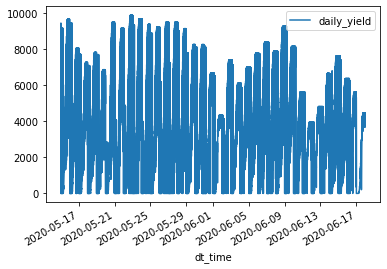

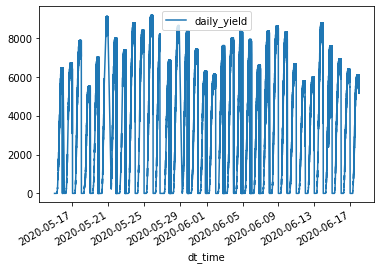

In [11]:
#The Below Code is use to Plot the line Graph
# We have plotted this line graph just to see if the data in the two column 
#is same or not
p2gen.plot(x = 'dt_time', y = 'daily_yield')
p1gen.plot(x = 'dt_time', y = 'daily_yield')

In [12]:

df['date'] = pd.to_datetime(df['dt_time']).dt.date

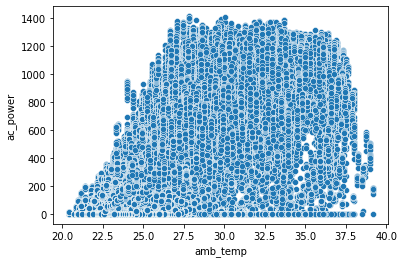

In [13]:
#Here We have Plotted A Series of Scatter plot between the Varible And the Types
#of power
sns.scatterplot(data=df, x="amb_temp", y="ac_power")

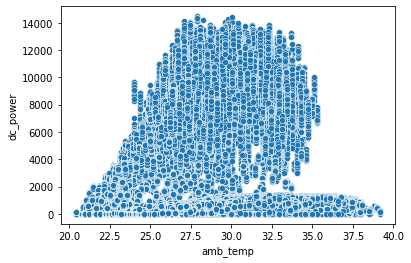

In [14]:
sns.scatterplot(data=df, x="amb_temp", y="dc_power")

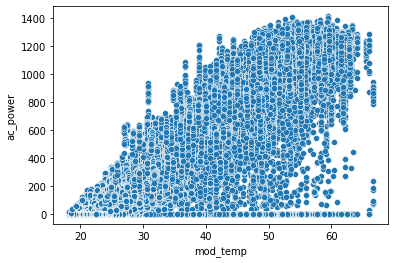

In [15]:
sns.scatterplot(data=df, x="mod_temp", y="ac_power")

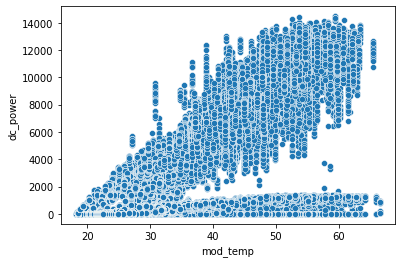

In [16]:
sns.scatterplot(data=df, x="mod_temp", y="dc_power")

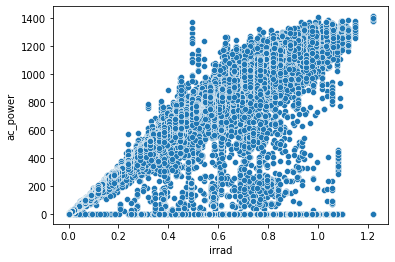

In [17]:
sns.scatterplot(data=df, x="irrad", y="ac_power")

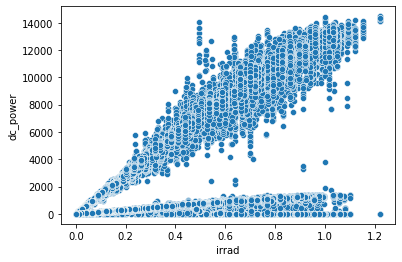

In [18]:
sns.scatterplot(data=df, x="irrad", y="dc_power")

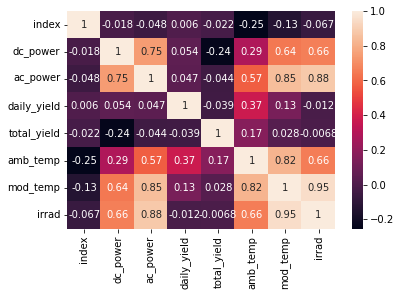

In [19]:
# The Below code is use to show the heat map 
#We have defined a function of the Heat map and then passed the values
# in the function to check the correlation between the Varibles
def heat_map(df, method = 'pearson', annot = True):
    sns.heatmap(df.corr(method), annot = annot,)

heat_map(df)

In [20]:
# The Below Code is use to convert a column to a categorical type 
# The Below Step is done to simplify the process 
df.simp_source_x = df.simp_source_x.astype('category')
df.plant_id_new_x = df.plant_id_new_x.astype('category')

In [21]:

df1 = df.loc[df['dc_power']>0].copy()
df1 = df.loc[df['ac_power']>0].copy()
df1 = df1[['ac_power', 'dc_power', 'amb_temp', 'mod_temp', 'irrad', 'simp_source_x', 'plant_id_new_x']].copy()
print(df1.corr())


          ac_power  dc_power  amb_temp  mod_temp     irrad
ac_power  1.000000  0.627009  0.468495  0.891073  0.963920
dc_power  0.627009  1.000000  0.052895  0.568568  0.606793
amb_temp  0.468495  0.052895  1.000000  0.714348  0.476898
mod_temp  0.891073  0.568568  0.714348  1.000000  0.916668
irrad     0.963920  0.606793  0.476898  0.916668  1.000000


In [22]:
#The Below Code is use to create a function which will plot the graph be

  

In [23]:
#The Below Code is use to Split the data into the test data and the split data 
# we have Sptil the Data into the 75% Train and 25% Split Data and Have Concidered
# the Random Value as 11 

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


def lin_reg(X,y,test_size,scale):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11)
    reggression = LinearRegression().fit(X, y)
    pred = reggression.predict(X_test)
    print ('rmse: ',mean_squared_error(y_test, pred, squared = False))
    print('r2: ', r2_score(y_test, pred))
    
    #plot_pred_actual(y_test, pred, scale)
    return pred

In [24]:
# The Below code is use to Prepare the data to put  into the model for 
#the Traning Phase

X= df1[['amb_temp', 'mod_temp', 'irrad',
       'simp_source_x', 'plant_id_new_x']].copy().to_numpy()

y_ac = df1['ac_power'].copy().to_numpy()
y_dc = df1['dc_power'].copy().to_numpy()

pred_ac = lin_reg(X,y_ac,20,'linear')

rmse:  95.14338877109662
r2:  0.9348196071498647


In [25]:
# The Below code is use to Prepare the data to put  into the model for 
#the Traning With the Min and the Max Scalling
from sklearn.preprocessing import MinMaxScaler
X1= df1[['amb_temp', 'mod_temp', 'irrad',
       'simp_source_x', 'plant_id_new_x', 'ac_power']].copy().to_numpy()
scaler = MinMaxScaler()
scaler.fit(X1)
X1= scaler.transform(X1)
y_ac = X1[:,5]
X1= X[:,0:5]
pred_ac2 = lin_reg(X1,y_ac,20,'linear')

rmse:  0.06744512229653168
r2:  0.9348196071498647


In [26]:
# The Below code is use to give the Properties of the XGBoost WE used this 
#XGBoost to Boost the Peformance of the model 
xgb_params = dict(
    max_depth=8,learning_rate=00.1, n_estimators=400, min_child_weight=2,                   
    colsample_bytree=0.8,subsample=0.8,reggression_alpha=0.6,reggression_lambda=0.8,         
    num_parallel_tree=2,                  
)

In [27]:
#The Below created Function is use to Get the Linear Regression Score of the data

def Linear_Regression_Score(X, y, model=XGBRegressor(**xgb_params)):
    
    for name in X.select_dtypes(['category']):
        X[name] = X[name].cat.codes
      
    y_log = np.log(y)
    
    score = cross_val_score(model,X, y_log, cv=5, scoring = 'neg_mean_squared_error')
    score = -1 *score.mean()
    score = np.sqrt(score)
    return(score)
    

In [28]:
# The Below Code is use to Get the SCore FOr the Linear Regression Model Using the XG Boost  

y_ac = df1['ac_power'].copy()
y_dc = df1['dc_power'].copy()
X = df1[['amb_temp', 'mod_temp', 'irrad', 'simp_source_x', 'plant_id_new_x']].copy()

Linear_Regression_Score(X,y_dc, model=XGBRegressor(**xgb_params))

[03:36:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:37:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:37:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:38:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:39:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.2830455777866298

In [29]:
# The Below Code is USe to Get the Model to make some Predection for the Question 
#that we have to Find Ans for

y_ac = df1['ac_power'].copy()
y_dc = df1['dc_power'].copy()
X1= df1[['amb_temp', 'mod_temp', 'irrad', 'simp_source_x', 'plant_id_new_x']].copy()
for name in X.select_dtypes(['category']):
        X[name] = X[name].cat.codes

X_train, X_test, y_train, y_test = train_test_split(X, y_ac, test_size=0.5, random_state=8)

xgb = XGBRegressor(**xgb_params)
xgb.fit(X_train, y_train)

[03:39:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.8, max_depth=8, min_child_weight=2,
             n_estimators=400, num_parallel_tree=2, reggression_alpha=0.6,
             reggression_lambda=0.8, subsample=0.8)

In [30]:
# Getting the Values Which the Model Predicted
y_ac_pred = xgb.predict(X_test)

print ('rmse: ',mean_squared_error(y_test, y_ac_pred, squared = False))
print('r2: ', r2_score(y_test, y_ac_pred))


rmse:  72.03585629135338
r2:  0.9627023592673184


In [31]:
# The Below Code is use to Make the Predection with the Above Trained Model

y_ac = df1['ac_power'].copy()
y_dc = df1['dc_power'].copy()
X1= df1[['amb_temp', 'mod_temp', 'irrad', 'simp_source_x', 'plant_id_new_x']].copy()
for name in X.select_dtypes(['category']):
        X[name] = X[name].cat.codes

X_train, X_test, y_train, y_test = train_test_split(X, y_ac, test_size=0.5, random_state=8)

xgb = XGBRegressor(**xgb_params)
xgb.fit(X_train, y_train)

[03:39:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.8, max_depth=8, min_child_weight=2,
             n_estimators=400, num_parallel_tree=2, reggression_alpha=0.6,
             reggression_lambda=0.8, subsample=0.8)

In [32]:
#The Code Gives Us the R2 and RMSE value after the XG Boost and we can crearly 
#see The Difference between the above and below R2 value
y_ac_pred = xgb.predict(X_test)


print ('rmse: ',mean_squared_error(y_test, y_ac_pred, squared = False))
print('r2: ', r2_score(y_test, y_ac_pred))



rmse:  72.03585629135338
r2:  0.9627023592673184


In [33]:
# The Below Code is use to Merge the 2 Dataframes of the plant 1 genration
#and Plant 2 genration Together and then removing the unwanted column

p1gen_merge = pd.merge(p1gen, p1wea, how='inner', on = 'dt_time')
p2gen_merge = pd.merge(p2gen, p2wea, how='inner', on = 'dt_time')
df = pd.concat([p1gen_merge,p2gen_merge])
df = df[['dt_time','plant_array_x','dc_power','ac_power','daily_yield','total_yield','amb_temp','mod_temp','irrad','simp_source_x','plant_id_new_x']]
df['date'] = pd.to_datetime(df['dt_time']).dt.date
df.columns = ['dt','plant_array','dc_power','ac_power','daily_yield','total_yield','amb_temp','mod_temp','irrad','array','plant','date']


In [34]:
#The Below Code is use to Check the Avg Power of a solar power Plant and see
# if the Plant is producing Zero power  
avg_period_power = df.pivot_table(index = ['plant', 'array'], columns = 'date', values = 'daily_yield', aggfunc = max)
avg_period_power.reset_index(inplace = True)

In [38]:
# The Below Code is use to FInd the Avrage power genrated of all the power plants
# We are finding this Avrage power to comapare the power plants with a Standard value
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
avg_period_power['average_daily_power_yield'] = avg_period_power.iloc[:,-34:].mean(axis = 1).copy()

avg_period_power

date,plant,array,2020-05-15,2020-05-16,2020-05-17,...,2020-06-14,2020-06-15,2020-06-16,2020-06-17,average_daily_power_yield
0,1,0,5754.0,6292.000000,7045.0,...,4012.0,6275.000000,5848.0,5521.0,6665.920415
1,1,1,6357.0,6592.000000,7759.0,...,7487.0,6846.000000,6318.0,6034.0,7377.977148
2,1,10,6383.0,6705.000000,7867.0,...,7590.0,6916.000000,6396.0,6110.0,7475.043144
3,1,11,5707.0,6138.000000,6928.0,...,3958.0,6192.000000,5757.0,5460.0,6559.837370
4,1,12,6418.0,6438.000000,7519.0,...,7369.0,6777.000000,6305.0,5957.0,7327.991349
...,...,...,...,...,...,...,...,...,...,...,...
39,2,5,8458.0,4510.933333,5519.0,...,7310.0,7310.000000,5604.0,3968.0,4744.055940
40,2,6,9234.0,7542.000000,6717.0,...,7445.0,7445.000000,6151.0,4121.0,5981.482699
41,2,7,7800.0,5807.000000,6481.0,...,3304.0,3304.000000,5526.0,4441.0,7075.832612
42,2,8,9475.0,7762.000000,7041.0,...,6277.0,6296.142857,6263.6,4239.0,6826.952747


In [39]:
# The Below Code is use to compare all the solar power plant array with the
# avg that we calculated to find out the Suboptimally peforming solar array

def peform_op (df ,plant, Title):
    
    array_monthly_average = df.loc[df['plant']==plant].copy()
    array_monthly_average = array_monthly_average[['plant','array', 'average_daily_power_yield']]
    avg = array_monthly_average['average_daily_power_yield'].mean()
    array_monthly_average['performance in %'] = ((array_monthly_average['average_daily_power_yield'] - avg) / avg) *100
    array_monthly_average.sort_values(by = 'performance in %', inplace=True)
    
    array_monthly_average.plot(x = 'array', y = 'performance in %', kind = 'bar', figsize = (20,10), title = Title, ylabel = '%' )   

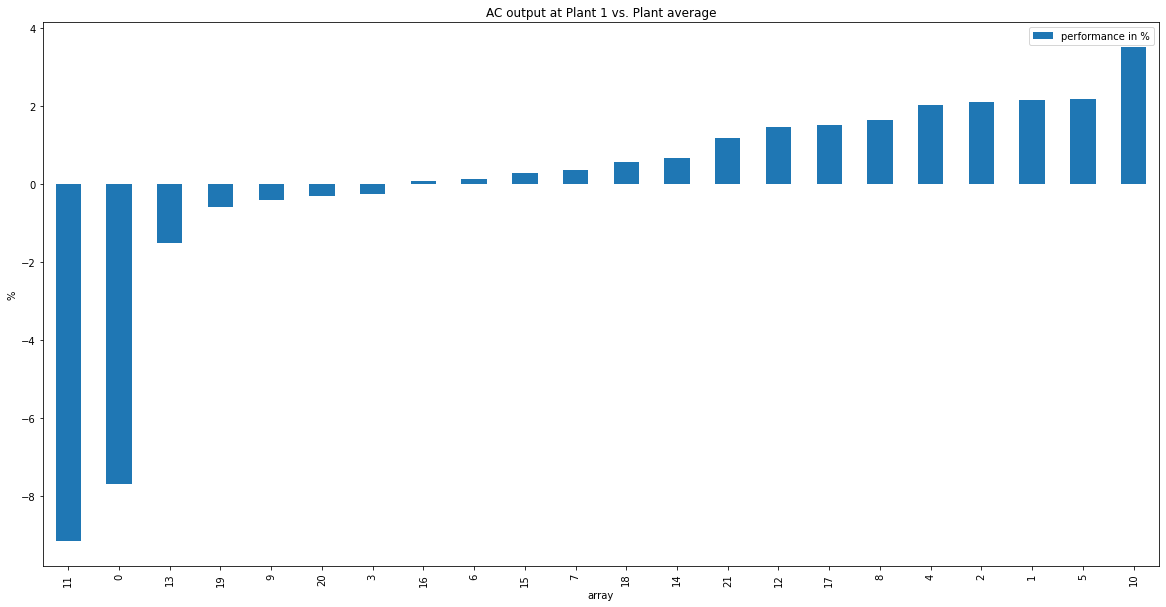

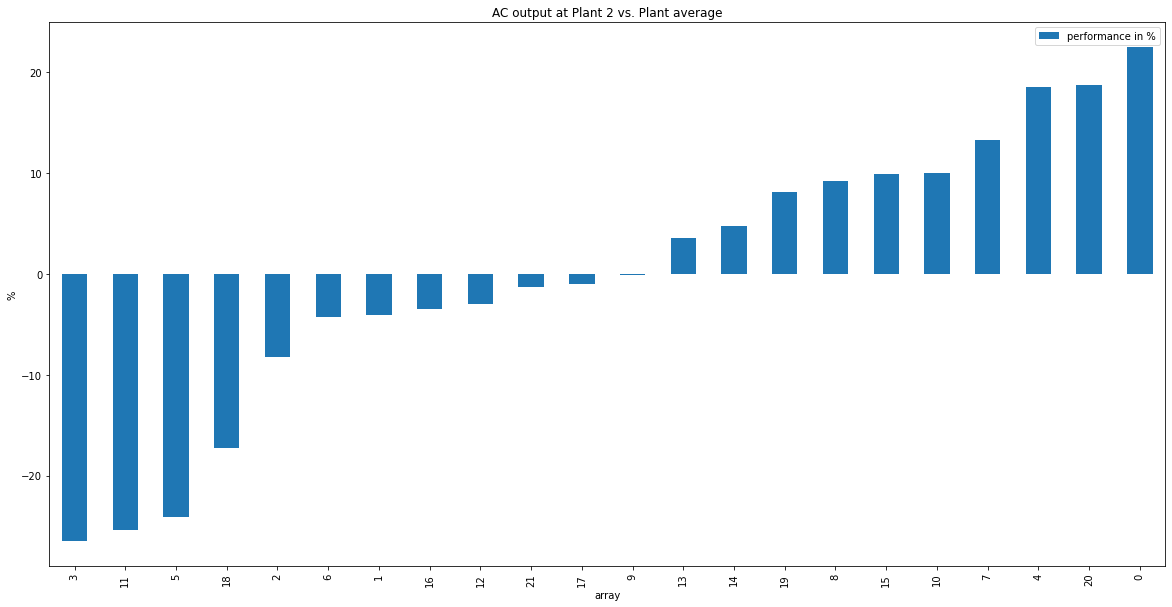

In [40]:
# The Below Code is use to Plot the Graph Between the Ac Output and the PLant Avg
# With the Help of this plot we get to know that which array is not peforming well
peform_op(avg_period_power, '1', 'AC output at Plant 1 vs. Plant average')
peform_op(avg_period_power, '2', 'AC output at Plant 2 vs. Plant average')

In [41]:
# The Below Code is use to compare the Peformance of all 
#the solar power plant array with the avg that we calculated to find out the Suboptimally peforming solar array
df.head()
df['irrad_yield'] = df['daily_yield'] / df['irrad']
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df['irrad_yield'] = df['irrad_yield'].fillna(0)
df.irrad_yield.value_counts()

irrad_df = df.pivot_table(index = ['plant', 'array'], values = ['irrad_yield'], aggfunc = np.mean)
irrad_df.reset_index(inplace = True)
irrad_df = pd.DataFrame(data = irrad_df)

In [42]:
# The Below COde is use to Create a function to Check and compare the Solar Power plant
def peform_op_irrad (df,col,plant, Title):
    df[col] = df[col].round(2).copy()
    df.sort_values(col, inplace = True)
    df1 = df.loc[df['plant'] == plant].copy()
    avg = df1[col].mean()
    df1['performance_%'] = ((df1[col] - avg) / avg) *100
    return df1.plot(x = 'array', y = 'performance_%', kind = 'bar', figsize = (20,10), title = Title)
    

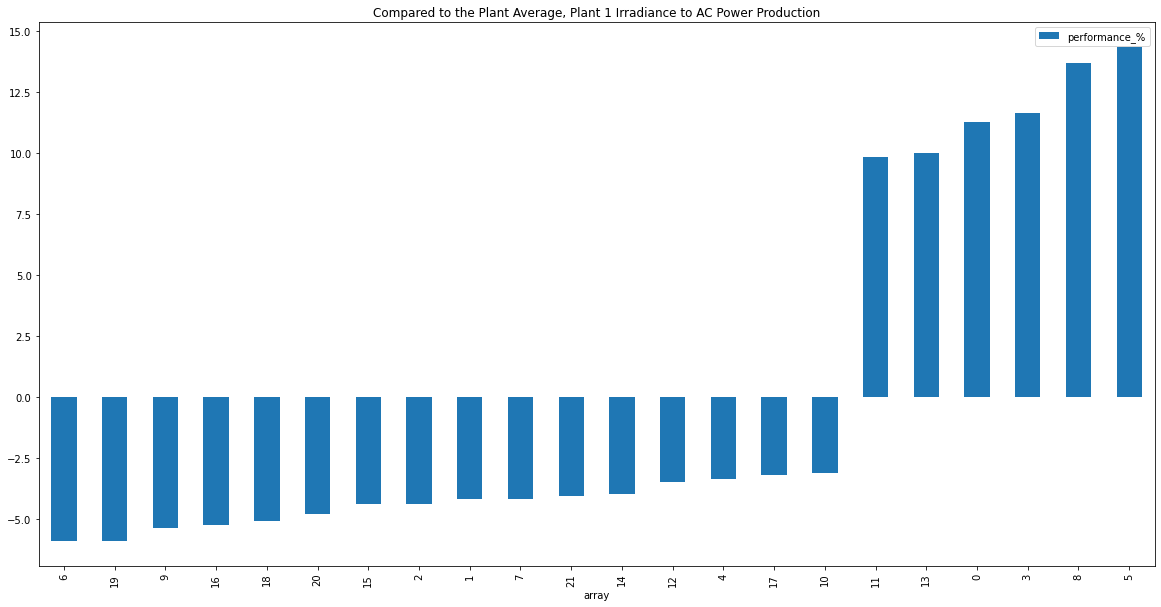

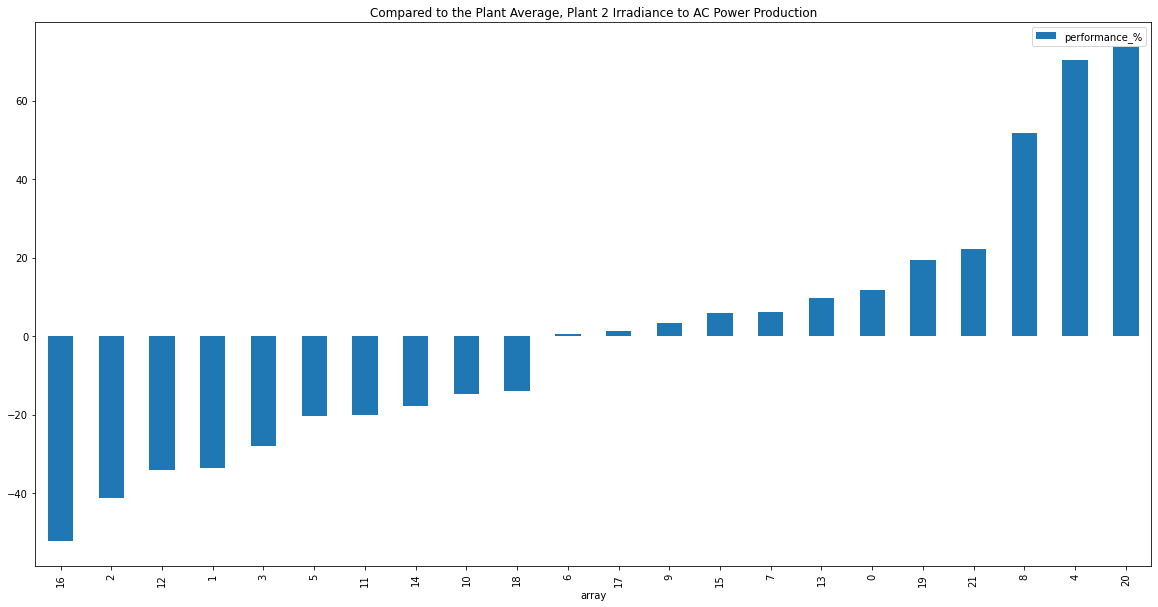

In [43]:
# The Below Code is use to Plot the Graph Between the Irradiance and the AC Power Production
# With the Help of this plot we get to know that which array is not peforming well
peform_op_irrad(irrad_df, 'irrad_yield', '1', 'Compared to the Plant Average, Plant 1 Irradiance to AC Power Production')
peform_op_irrad(irrad_df, 'irrad_yield', '2', 'Compared to the Plant Average, Plant 2 Irradiance to AC Power Production')